ForGroup : 26194
GroupGal : 83093
StellarMasses : 114685
EnvMeasures : 67996
visualMorph : 38795
Join GroupGal & StellarMasses 43463
GroupGal & StellarMasses
['CATAID', 'RA', 'Dec', 'Z_1', 'Rpetro', 'DM_100_25_75', 'SURVEY_CODE_1', 'SigErr', 'GroupID', 'RankIterCen', 'SepIterCen', 'CoSepIterCen', 'AngSepIterCen', 'RankBCG', 'SepBCG', 'CoSepBCG', 'AngSepBCG', 'RankCen', 'SepCen', 'CoSepCen', 'AngSepCen', 'Z_2', 'nQ', 'SURVEY_CODE_2', 'SURVEY_CLASS', 'Z_TONRY', 'fluxscale', 'zmax_19p8', 'zmax_19p4', 'zmax_19p0', 'zmax_17p8', 'nbands', 'S2N', 'PPP', 'logmstar', 'dellogmstar', 'logmoverl_i', 'dellogmoverl_i', 'logage', 'dellogage', 'logtau', 'dellogtau', 'logmintsfh', 'dellogmintsfh', 'logmremnants', 'dellogmremnants', 'metal', 'delmetal', 'extBV', 'delextBV', 'logLWage', 'dellogLWage', 'gminusi', 'delgminusi', 'uminusr', 'deluminusr', 'gminusi_stars', 'uminusr_stars', 'C_logM_ur', 'C_logM_gi', 'C_logM_eBV', 'fitphot_u', 'delfitphot_u', 'absmag_u', 'delabsmag_u', 'absmag_u_stars', 'fitphot

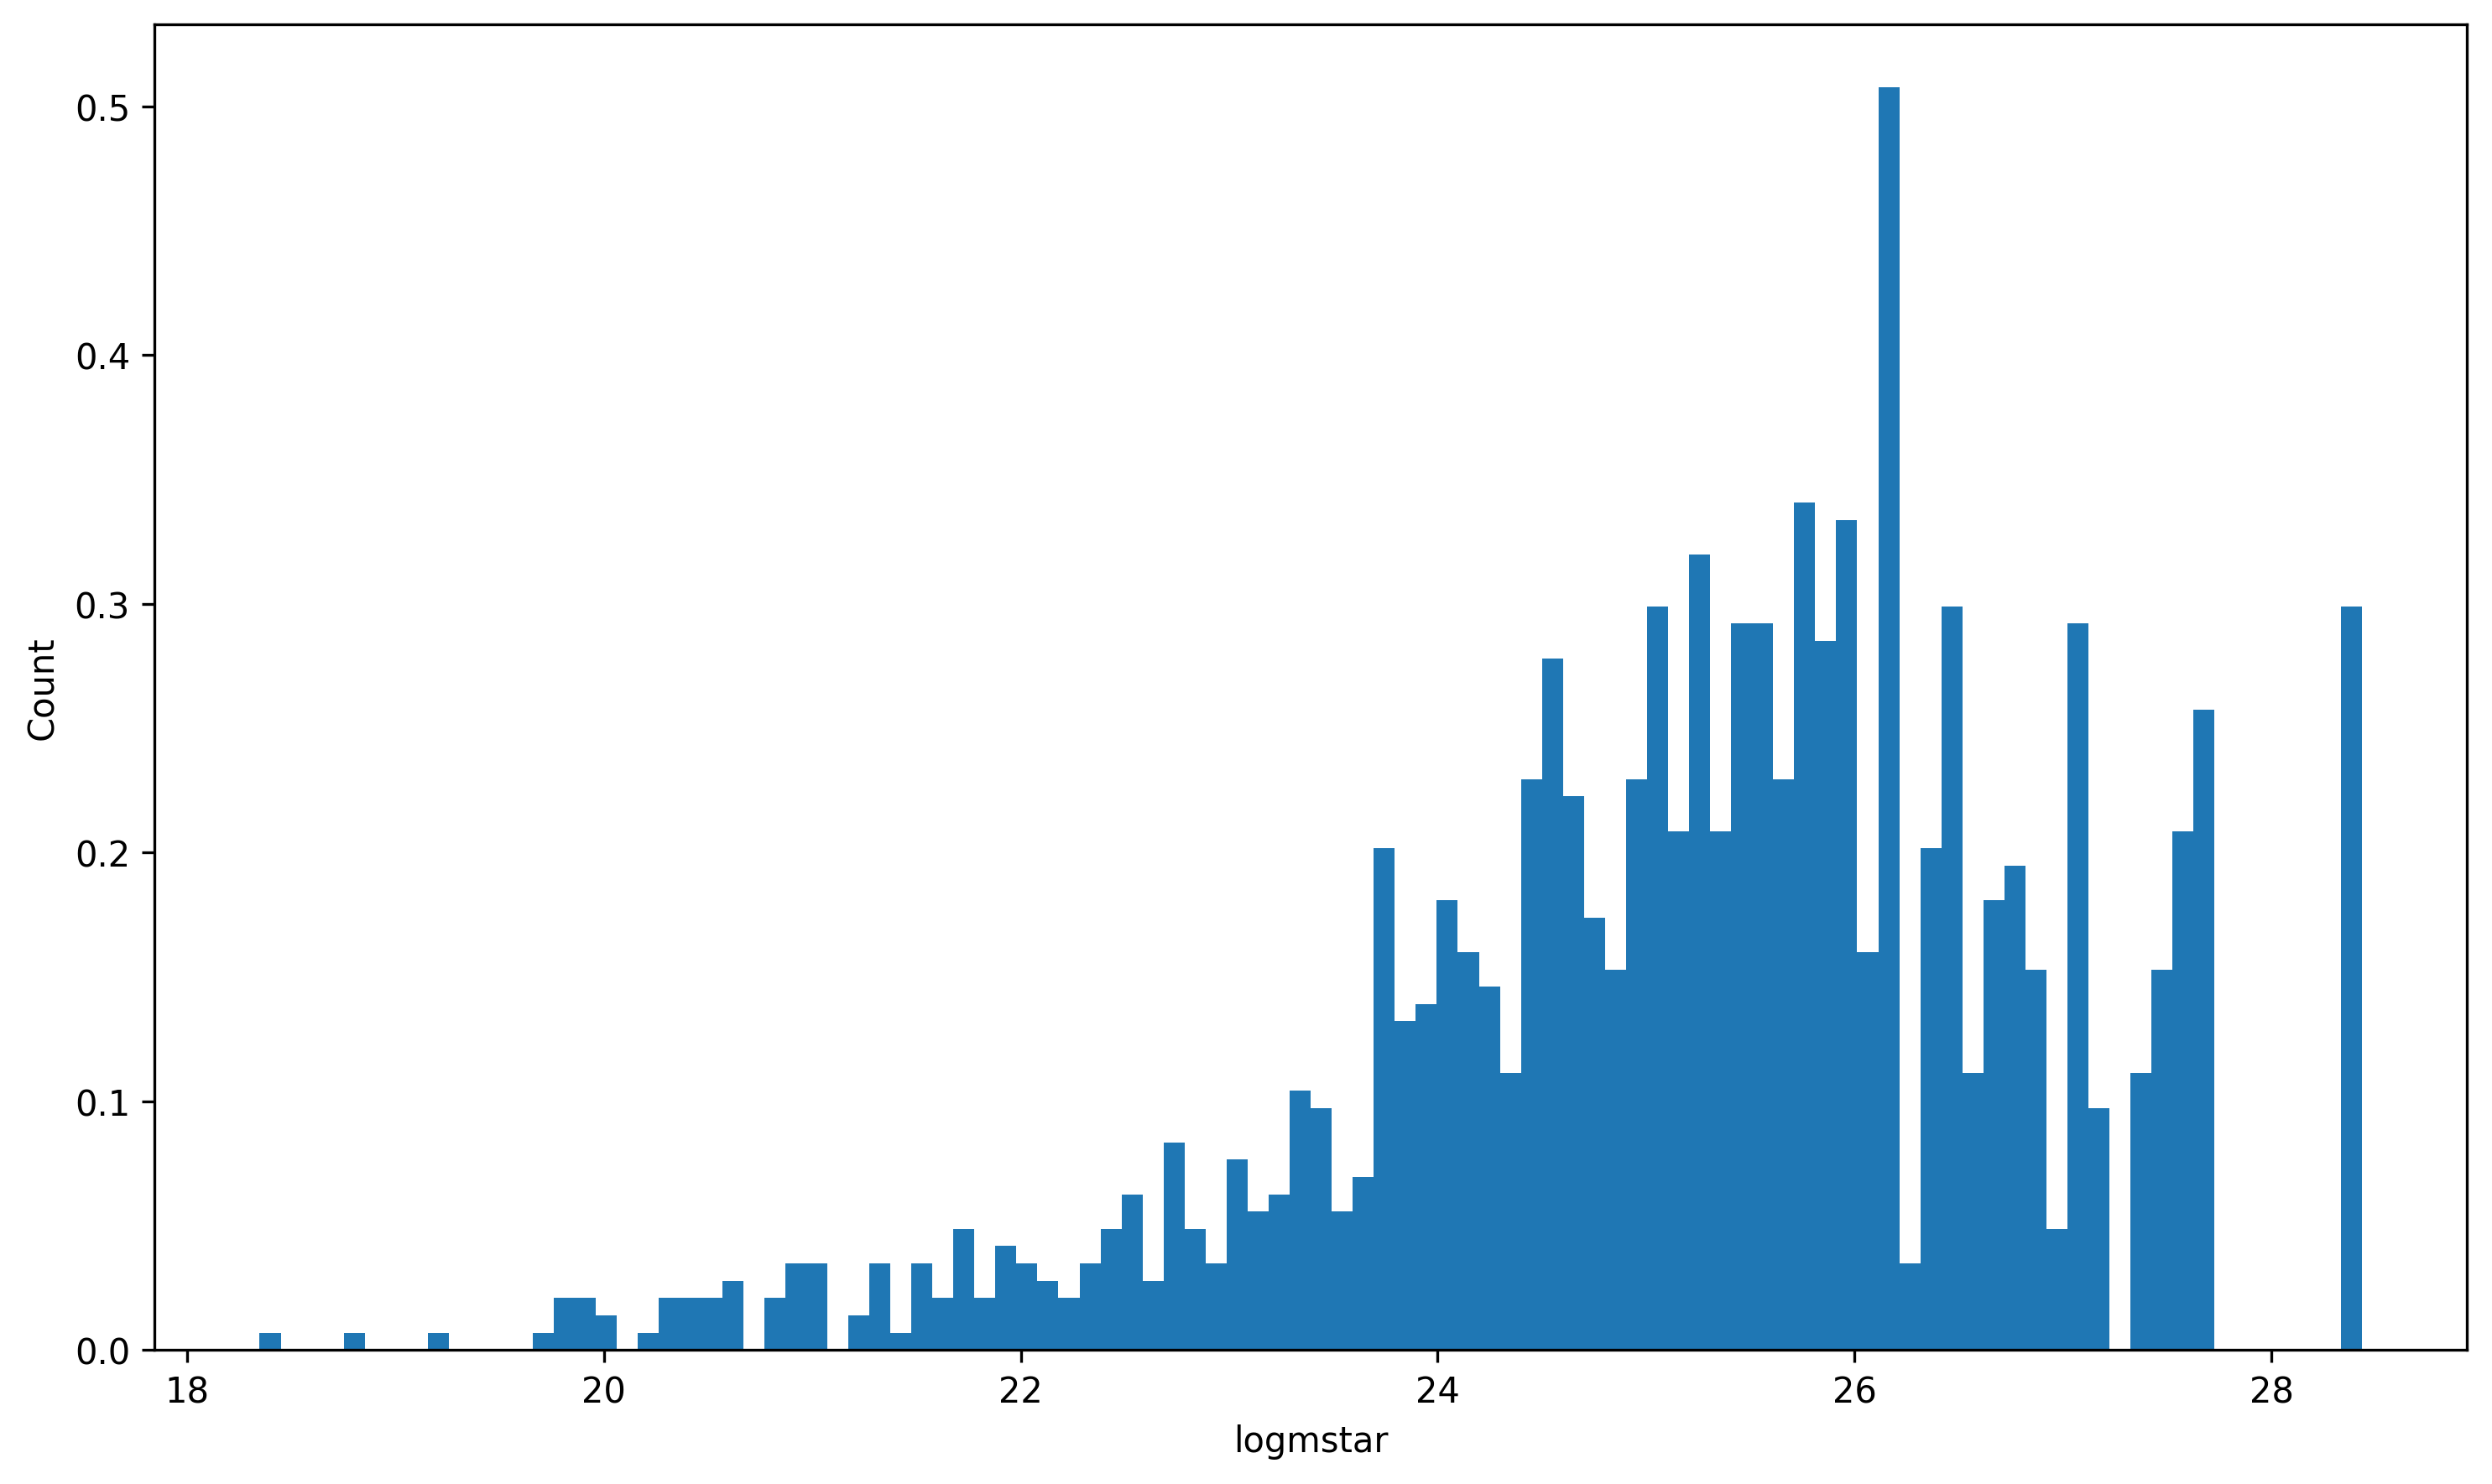

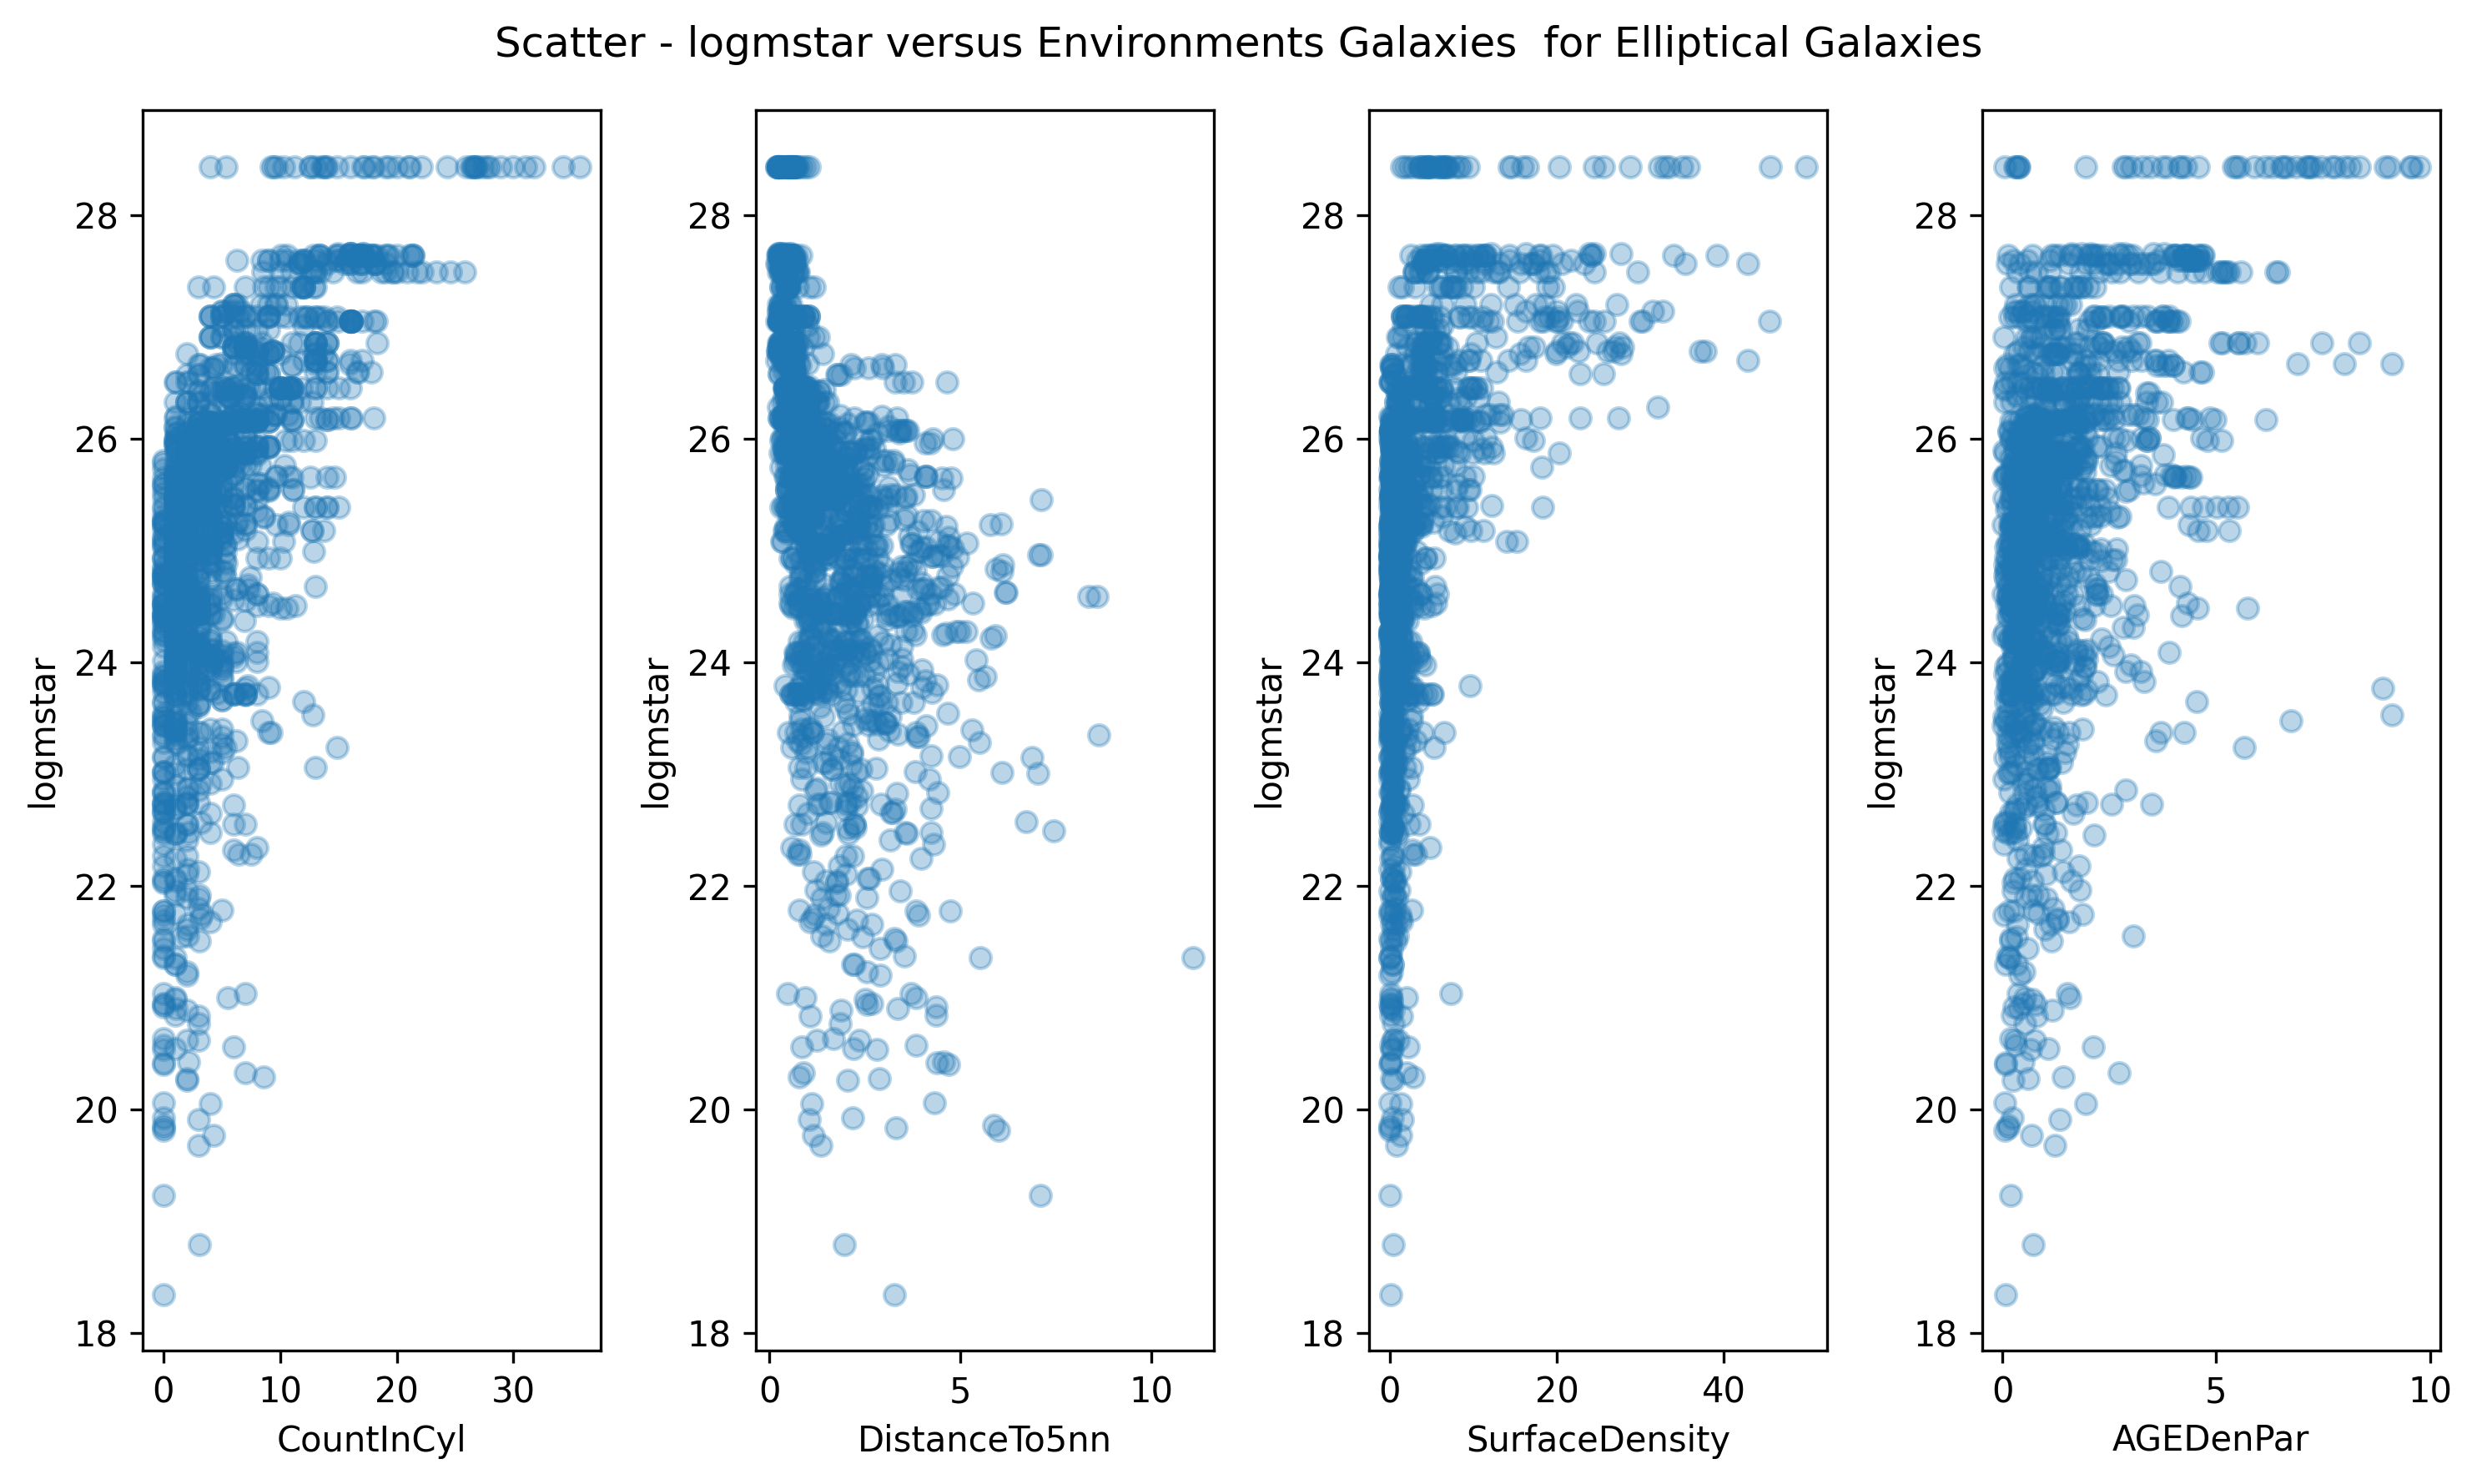

18.34842191646097
28.433443112875377
Non LOG - Spearman Correlation x: CountInCyl y: logmstar Correlation : 0.6753302565357093 T-Test : 1.5896883859398288e-190
Non LOG - Pearson Correlation x: CountInCyl y: logmstar Correlation : 0.6256421861872054 T-Test : 9.085675974412902e-156
Non LOG Linear Regresion x: CountInCyl y: logmstar slope : 0.18968132859081765 Intercept 24.18914682709527 Correlation 0.6256421861872051 Wald test 9.085675974408965e-156 0.006267574356742612
Non LOG - Spearman Correlation x: DistanceTo5nn y: logmstar Correlation : -0.6379505486194746 T-Test : 8.80600657194965e-164
Non LOG - Pearson Correlation x: DistanceTo5nn y: logmstar Correlation : -0.4796726451516933 T-Test : 6.16695401745108e-83
Non LOG Linear Regresion x: DistanceTo5nn y: logmstar slope : -0.5965699363039659 Intercept 26.220573725979555 Correlation -0.47967264515169317 Wald test 6.166954017446813e-83 0.02891895320660629
Non LOG - Spearman Correlation x: SurfaceDensity y: logmstar Correlation : 0.640638

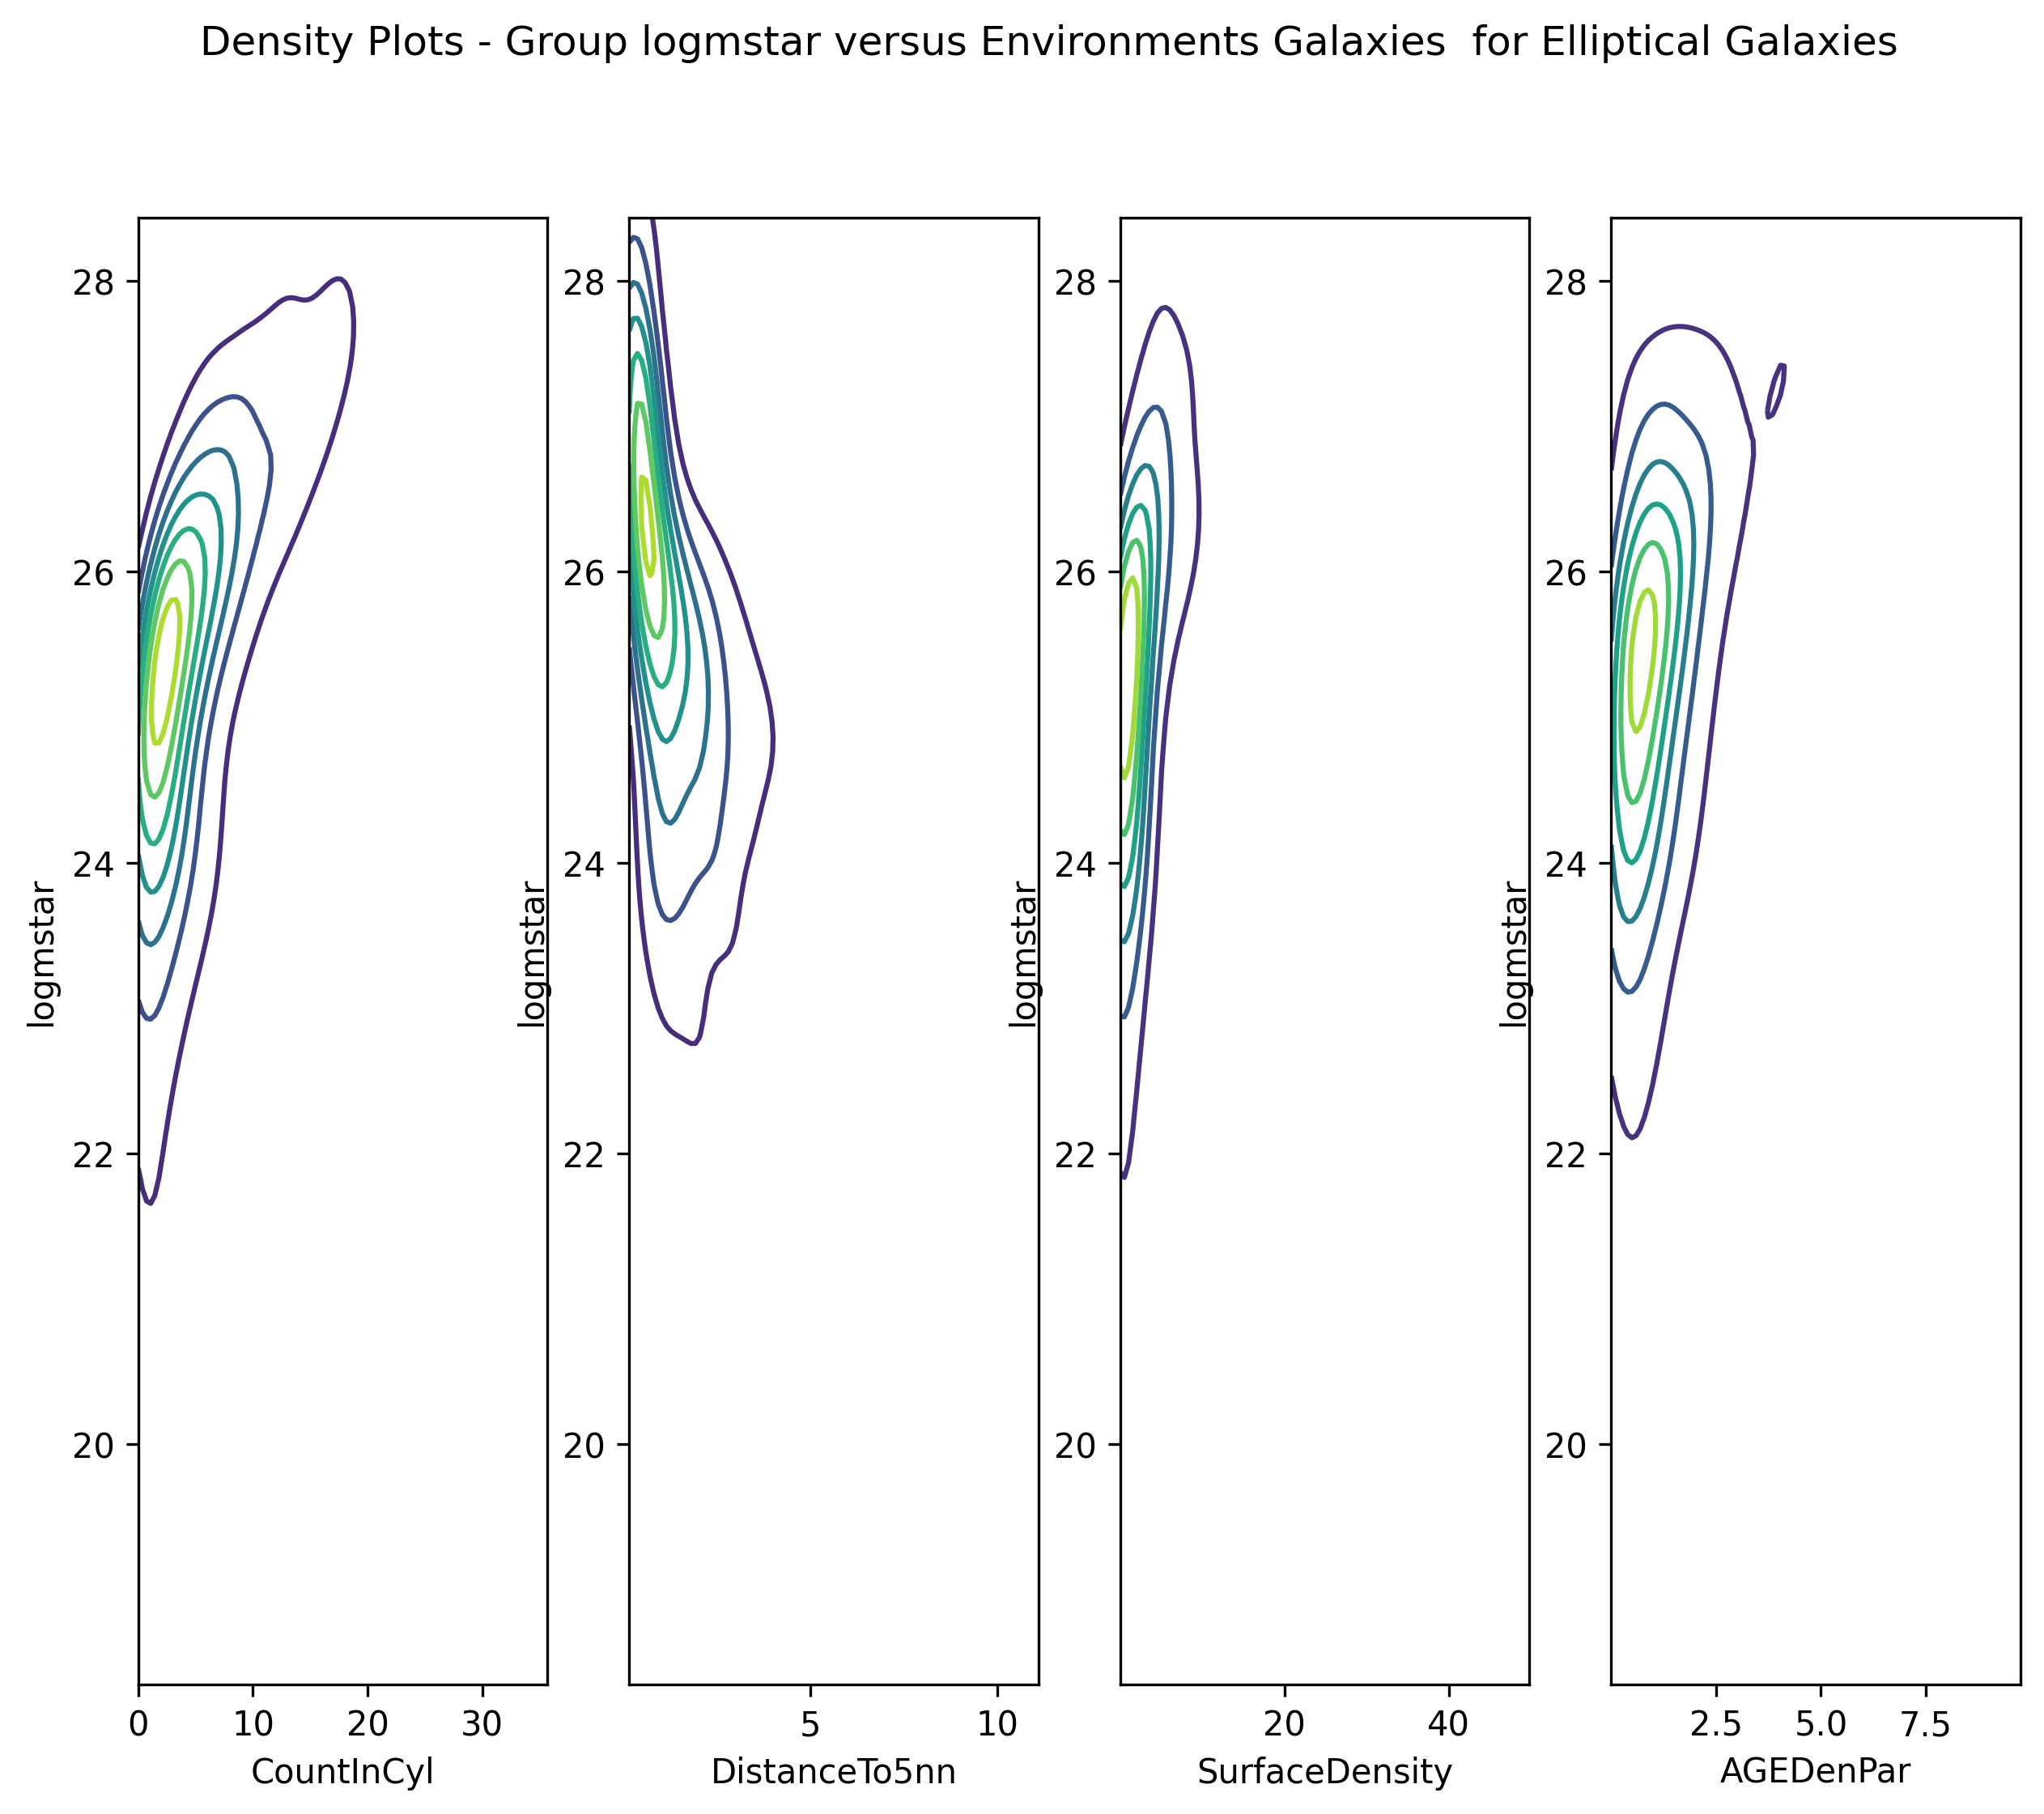

 yfield logmstar ymin 18.34842191646097 ymax 28.433443112875377

 xfield CountInCyl xmin 0.0 xmax 35.69200134277344
 xfield CountInCyl log values - xmin -4.605170249938965 xmax 3.575206756591797
Spearman Correlation x: CountInCyl y: logmstar Correlation : 0.6753302565357093 T-Test : 1.5896883859398288e-190
Pearson Correlation x: CountInCyl y: logmstar Correlation : 0.5369133069589644 T-Test : 2.756555328662412e-107
Linear Regresion x: CountInCyl y: logmstar slope : 0.4528991980822356 Intercept 24.8670142097661 Correlation 0.5369133069589646 Wald test 2.7565553286603255e-107 0.01885811264292142
 xfield DistanceTo5nn xmin 0.1850000023841858 xmax 11.090999603271484
 xfield DistanceTo5nn log values - xmin -1.6347557306289673 xmax 2.4070351123809814
Spearman Correlation x: DistanceTo5nn y: logmstar Correlation : -0.6379505486194746 T-Test : 8.80600657194965e-164
Pearson Correlation x: DistanceTo5nn y: logmstar Correlation : -0.5819005889764185 T-Test : 5.324668166937527e-130
Linear Regresio

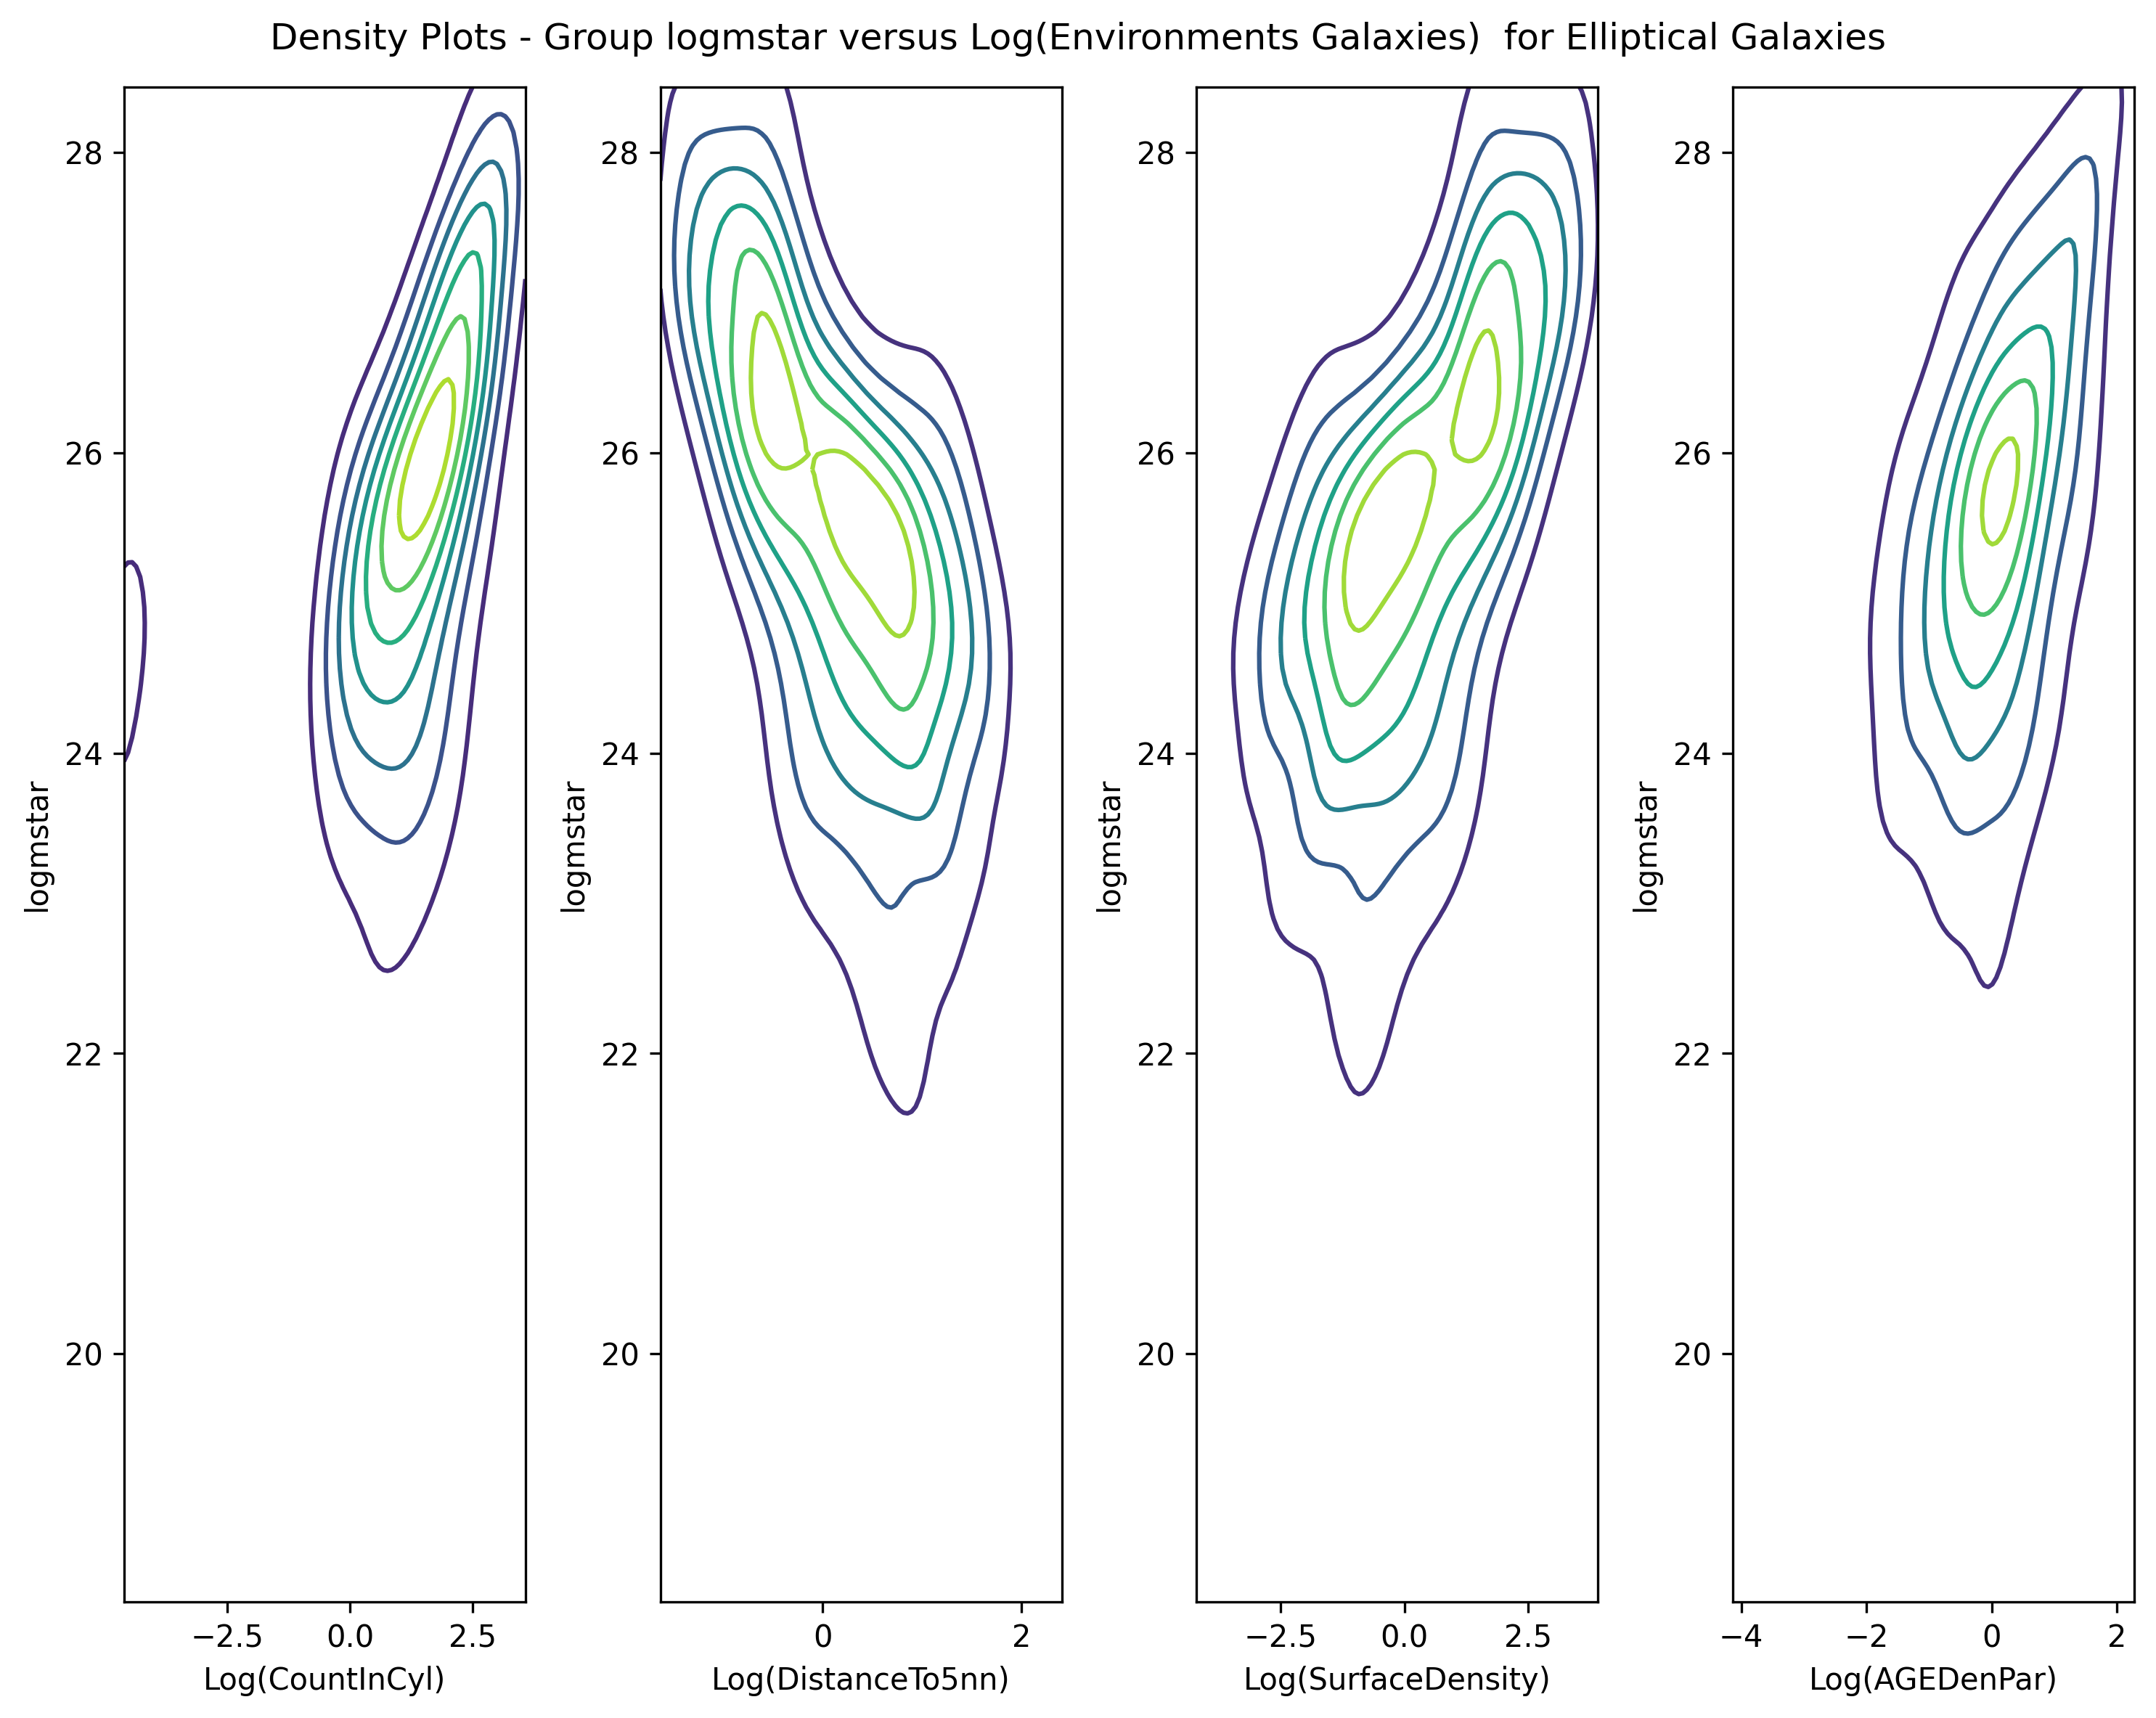

 yfield logmstar ymin 18.34842191646097 ymax 27.651376159085576

Spearman Correlation x: CountInCyl y: logmstar Correlation : 0.6485880134615335 T-Test : 6.63189712667949e-166
Pearson Correlation x: CountInCyl y: logmstar Correlation : 0.5147422218714168 T-Test : 2.0286949513145892e-94
Linear Regresion x: CountInCyl y: logmstar slope : 0.4166959074728758 Intercept 24.82572228839331 Correlation 0.5147422218714168 Wald test 2.02869495131774e-94 0.018676187320336456
Spearman Correlation x: DistanceTo5nn y: logmstar Correlation : -0.6171021146396162 T-Test : 6.207169088161602e-146
Pearson Correlation x: DistanceTo5nn y: logmstar Correlation : -0.5589279532036393 T-Test : 1.8362759019055757e-114
Linear Regresion x: DistanceTo5nn y: logmstar slope : -1.1154109201641942 Intercept 25.3743656699723 Correlation -0.5589279532036393 Wald test 1.8362759019087218e-114 0.0445297249188188
Spearman Correlation x: SurfaceDensity y: logmstar Correlation : 0.6192709005363339 T-Test : 3.08958821563808e-147

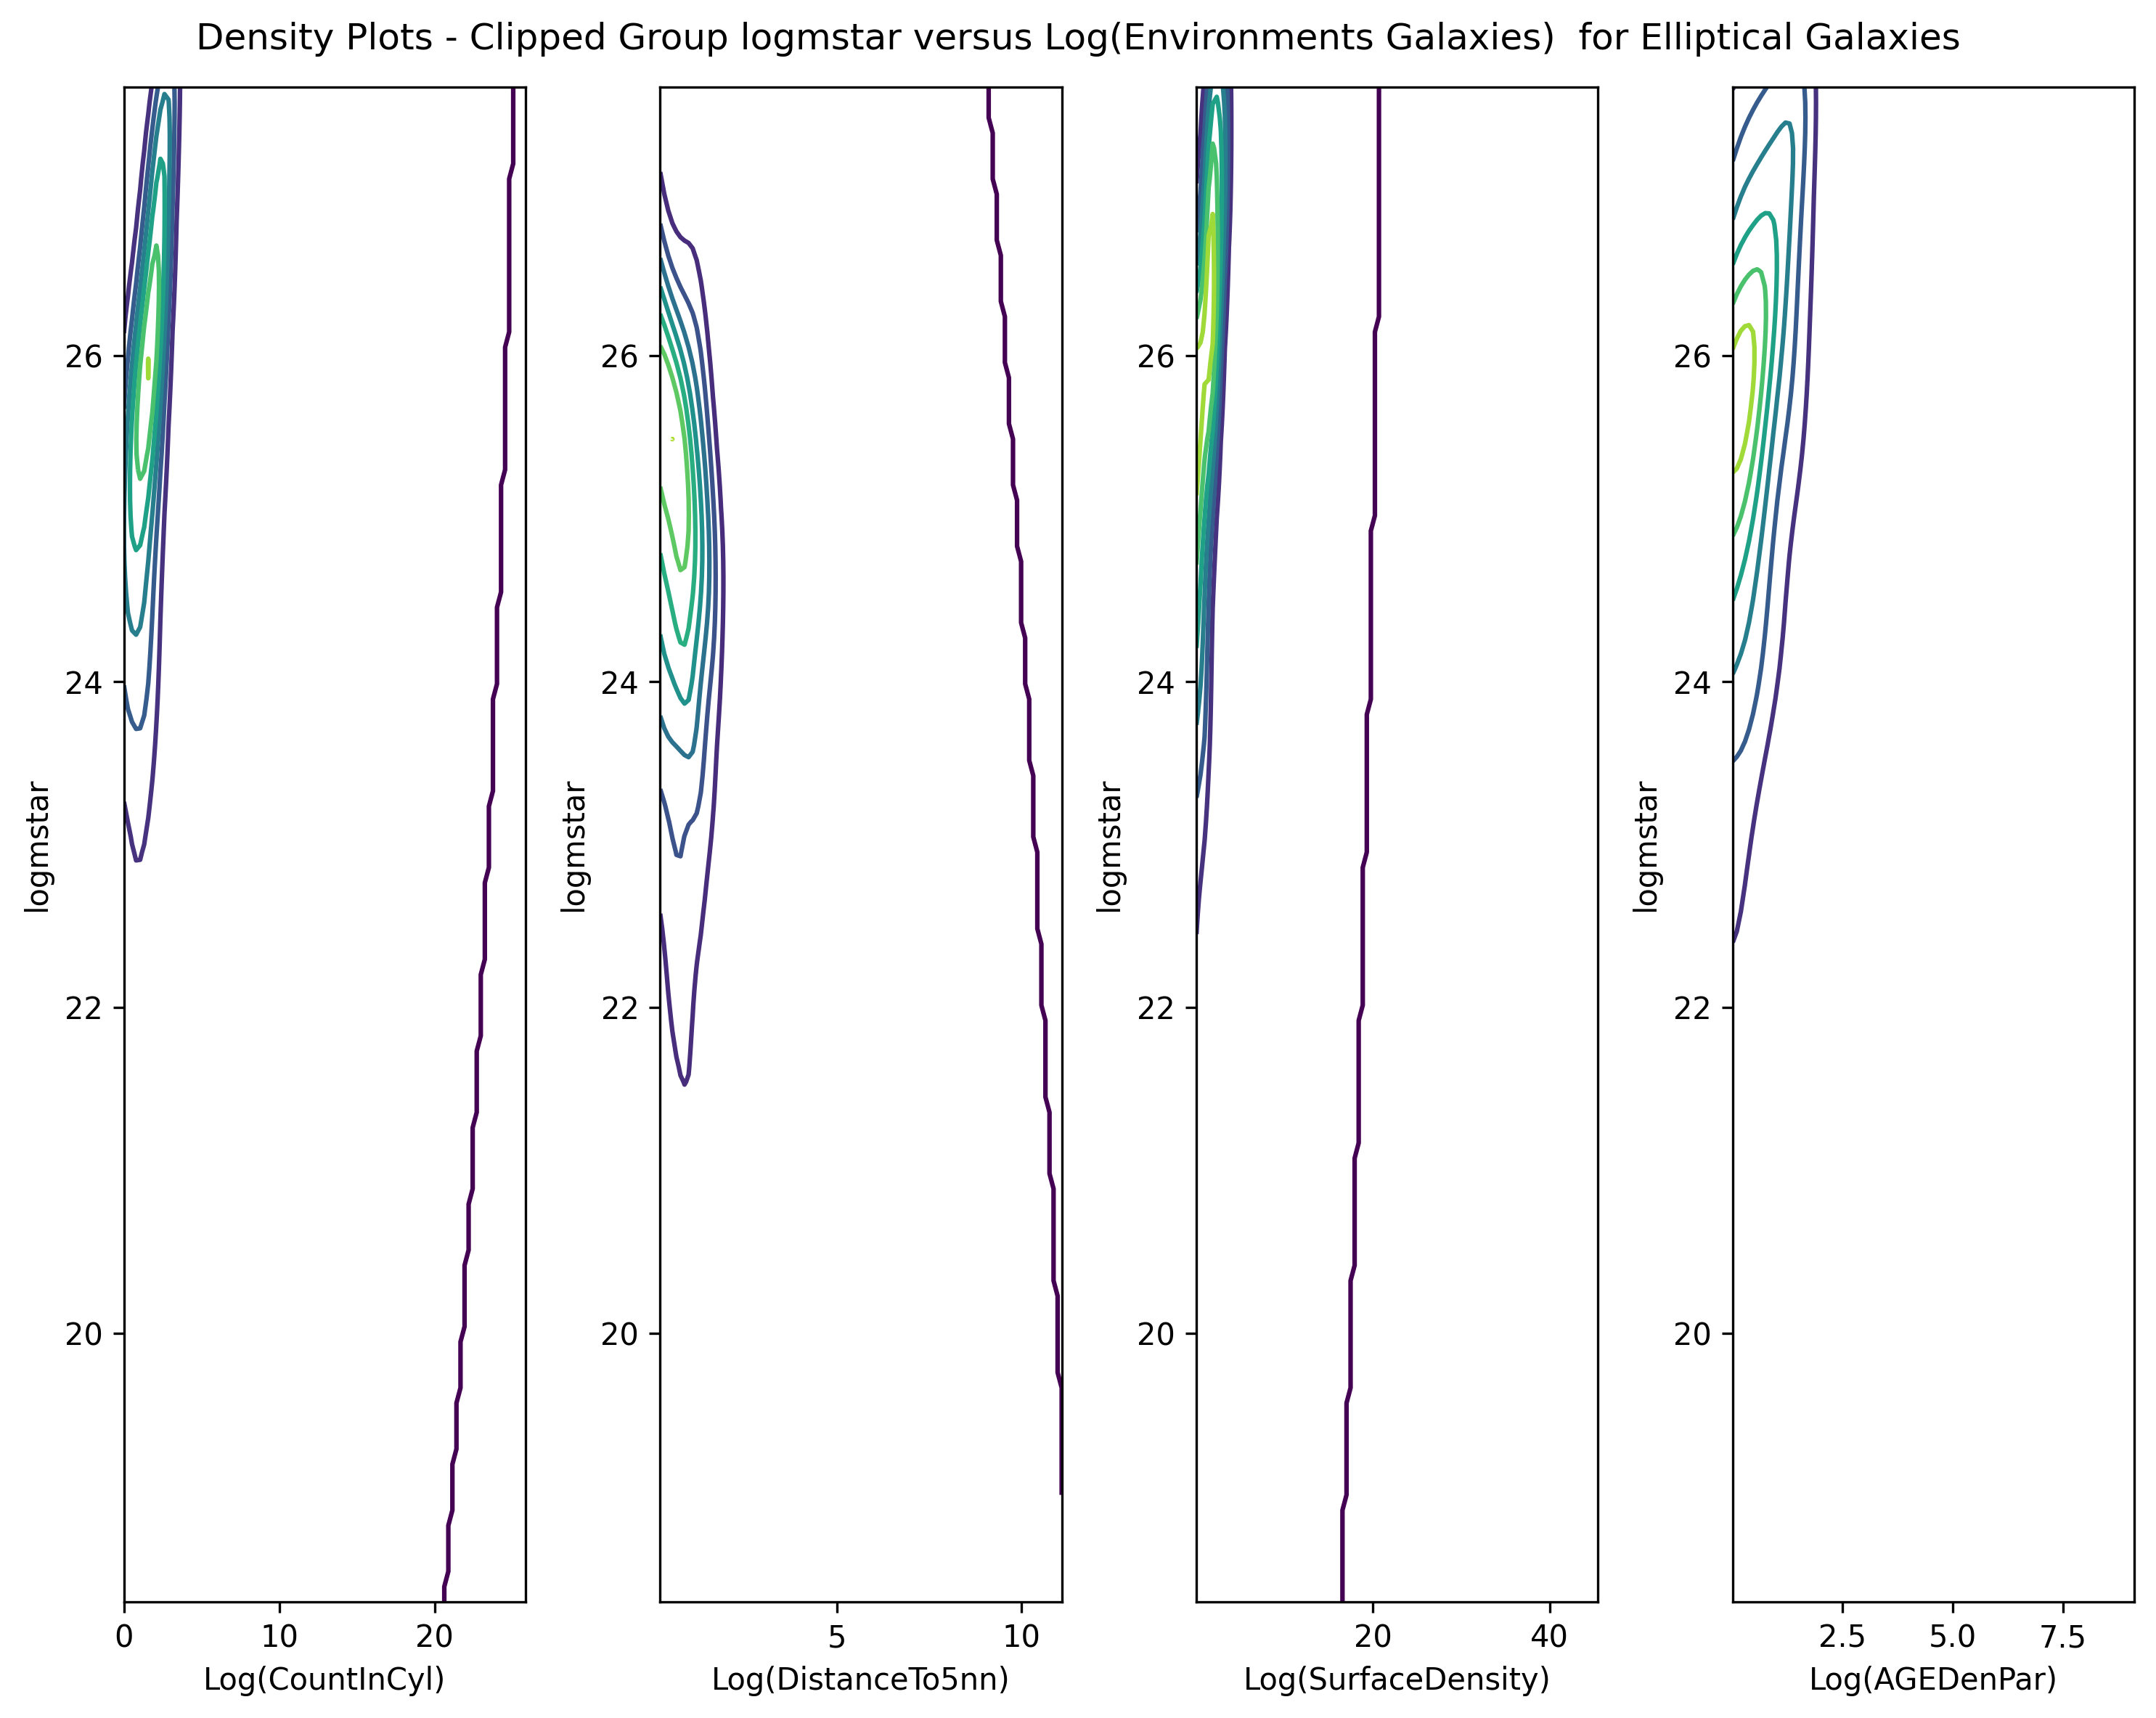

In [2]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd


ForGroup = Table.read('../../GAMA_DATA/G3CFoFGroupv10.fits')
print(f"ForGroup : {len(ForGroup)}")
## Clean Data

GroupGal = Table.read('../../GAMA_DATA/G3CGalv10.fits')
# Clean data
GroupGal = GroupGal[GroupGal['GroupID'] > 0 ]
print(f"GroupGal : {len(GroupGal)}")

StellarMasses = Table.read('../../GAMA_DATA/StellarMassesv19.fits')
# Clean Data
#StellarMasses = StellarMasses[StellarMasses['uminusr'] > 0.001]
#StellarMasses = StellarMasses[StellarMasses['logmstar'] > 0.001]
#StellarMasses = StellarMasses[StellarMasses['metal'] > 0.001]


StellarMasses = StellarMasses[StellarMasses['uminusr'] > 0.01]
StellarMasses = StellarMasses[StellarMasses['logmstar'] > 0.01]
StellarMasses = StellarMasses[StellarMasses['metal'] > 0.01]
print(f"StellarMasses : {len(StellarMasses)}")


envMeasures = Table.read('../../GAMA_DATA/EnvironmentMeasuresv05.fits')
print(f"EnvMeasures : {len(envMeasures)}")
# Clean Data
envMeasures = envMeasures[envMeasures['SurfaceDensity'] < 50]
envMeasures = envMeasures[envMeasures['AGEDenParFlag'] == 0]
envMeasures = envMeasures[envMeasures['CountInCylFlag'] == 0]


visualMorph = Table.read('../../GAMA_Data/VisualMorphologyv03.fits')
print(f"visualMorph : {len(visualMorph)}")
## Clean Data
visualMorph = visualMorph[visualMorph['ELLIPTICAL_CODE'] == 1]


DataLocalGroup = join(GroupGal,StellarMasses,keys='CATAID',join_type='inner')
print(f"Join GroupGal & StellarMasses {len(DataLocalGroup)}")
print('GroupGal & StellarMasses')
print(DataLocalGroup.colnames)

import math

# Sum uminsur, logmstar and metal over Local Group
DLG_Groups = DataLocalGroup.group_by('GroupID')
#GroupData = DLG_Groups['GroupID','uminusr','logmstar','metal'].groups.aggregate(np.sum)
GroupData = DLG_Groups['GroupID','logmstar'].groups.aggregate(lambda x: math.log(np.sum(10**(x))))
print(GroupData)


print('GroupData')
print(GroupData.colnames)
print('GroupGal')
print(GroupGal.colnames)

FinalData = join(GroupGal,GroupData,keys='GroupID',join_type='inner')
print(FinalData)
print(FinalData.colnames)

FinalData = join(FinalData,envMeasures,keys='CATAID',join_type='inner')
print('Joining Environment Measures '+str(len(FinalData)))
#print(FinalData.colnames)

FinalData = join(FinalData,visualMorph,keys='CATAID',join_type='inner')
print('Joining Visual Morph '+str(len(FinalData)))


alphaVal = .3
binCount = 100

RErange = FinalData
#RErange = GroupData


fig = plt.figure(figsize=(10, 6), dpi=300)
#fig.suptitle('Plot - Redness versus Environments Galaxies  for Elliptical Galaxies')
xfields = ['logmstar']


xn = np.linspace(0,100,100)
i = 1
for xfield in xfields :
    ax = fig.add_subplot(len(xfields),1,i)
    i += 1
    ax.set_ylabel('Count')
    ax.set_xlabel(xfield)
    ax.hist(RErange[xfield],bins=binCount, density=True)
fig.tight_layout()
plt.show()

                                                             
yfield = 'logmstar'

fig = plt.figure(figsize=(10, 6), dpi=300)
fig.suptitle('Scatter - '+yfield+' versus Environments Galaxies  for Elliptical Galaxies')
xfields = ['CountInCyl','DistanceTo5nn','SurfaceDensity','AGEDenPar']
i = 1
y = RErange[yfield]
for xfield in xfields :
    ax = fig.add_subplot(1, len(xfields), i)
    i += 1           
    ax.set_ylabel(yfield)
    ax.set_xlabel(xfield)
    x = RErange[xfield]
    ax.scatter(x,y,alpha=alphaVal,label=xfield)        
#fig.legend(loc="upper right")
#plt.axis([0, 3, 0, 0.8])
fig.tight_layout()
#fig.savefig('../../ChartsPlots/RedScatterEnvironments.png', dpi=300, bbox_inches='tight')                      
plt.show()

fig = plt.figure(figsize=(10, 8), dpi=300)
fig.suptitle('Density Plots - Group '+yfield+' versus Environments Galaxies  for Elliptical Galaxies')
xfields = ['CountInCyl','DistanceTo5nn','SurfaceDensity','AGEDenPar']
#xfields = ['GalData.CountInCyl','GalData.DistanceTo5nn','GalData.SurfaceDensity','GalData.AGEDenPar']
i = 1      
y = RErange[yfield]
ymin = min(y)
print(ymin)
ymax = max(y)
print(ymax)
for xfield in xfields :
    x = RErange[xfield]
    xmin = min(x)
    xmax = max(x)
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    ax = fig.add_subplot(1, len(xfields), i)
    ax.set_ylabel(yfield)
    ax.set_xlabel(xfield)
    i += 1           
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)
    #ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,extent=[xmin, xmax, ymin, ymax])
    #ax.imshow(np.rot90(Z), cmap='PuBu',extent=[xmin, xmax, ymin, ymax])
    #ax.imshow(np.rot90(Z), cmap='PuBu')
    ax.contour(X, Y, Z)
    #ax.plot(x, y, 'k.', markersize=2)
    #ax.set_xlim([xmin, xmax])
    #ax.set_ylim([ymin, ymax])
    r, p = stats.spearmanr(x,y)
    print(f"Non LOG - Spearman Correlation x: {xfield} y: {yfield} Correlation : {r} T-Test : {p}")
    r, p = stats.pearsonr(x,y)
    print(f"Non LOG - Pearson Correlation x: {xfield} y: {yfield} Correlation : {r} T-Test : {p}")
    m, c, r, p, se = stats.linregress(x,y)
    print(f"Non LOG Linear Regresion x: {xfield} y: {yfield} slope : {m} Intercept {c} Correlation {r} Wald test {p} {se}")
    
plt.show()                            
#fig.legend(loc="upper right")
#plt.axis([0, 3, 0, 0.8])
fig.tight_layout()
#fig.savefig('../../ChartsPlots/GroupDensityTotRmagEnvironments.png', dpi=300, bbox_inches='tight')
plt.show()


fig = plt.figure(figsize=(10, 8), dpi=300)
fig.suptitle('Density Plots - Group '+yfield+' versus Log(Environments Galaxies)  for Elliptical Galaxies')
#xfields = ['GalData.CountInCyl','GalData.DistanceTo5nn','GalData.SurfaceDensity','GalData.AGEDenPar']
xfields = ['CountInCyl','DistanceTo5nn','SurfaceDensity','AGEDenPar']
i = 1      
y = RErange[yfield]
ymin = min(y)
ymax = max(y)
print(f" yfield {yfield} ymin {ymin} ymax {ymax}\n")
for xfield in xfields :
    x = RErange[xfield]
    xmin = min(x)
    xmax = max(x)
    print(f" xfield {xfield} xmin {xmin} xmax {xmax}")
    x = np.log(RErange[xfield]+0.01)
    xmin = min(x)
    xmax = max(x)
    print(f" xfield {xfield} log values - xmin {xmin} xmax {xmax}")
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    ax = fig.add_subplot(1, len(xfields), i)
    ax.set_ylabel(yfield)
    ax.set_xlabel('Log('+xfield+')')
    i += 1           
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)
    #ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,extent=[xmin, xmax, ymin, ymax])
    #ax.imshow(np.rot90(Z), cmap='PuBu',extent=[xmin, xmax, ymin, ymax])
    
    #ax.imshow(np.rot90(Z), cmap='PuBu')
    ax.contour(X, Y, Z)
    
    #ax.plot(x, y, 'k.', markersize=2)
    #ax.set_xlim([xmin, xmax])
    #ax.set_ylim([ymin, ymax])
    r, p = stats.spearmanr(x,y)
    print(f"Spearman Correlation x: {xfield} y: {yfield} Correlation : {r} T-Test : {p}")
    r, p = stats.pearsonr(x,y)
    print(f"Pearson Correlation x: {xfield} y: {yfield} Correlation : {r} T-Test : {p}")
    m, c, r, p, se = stats.linregress(x,y)
    print(f"Linear Regresion x: {xfield} y: {yfield} slope : {m} Intercept {c} Correlation {r} Wald test {p} {se}")
#fig.legend(loc="upper right")
#plt.axis([0, 3, 0, 0.8])
fig.tight_layout()
fig.savefig('../../ChartsPlots/GroupDensity-Sum-logmstar-Environments.png', dpi=300, bbox_inches='tight')
plt.show()


small  = RErange[RErange['logmstar'] < 28]
#medium = RErange[RErange['uminusr'] > 150]
#medium = medium[medium['uminusr'] < 250]
#large  = RErange[RErange['uminusr'] > 100]

tables = [small]
for table in tables :
    fig = plt.figure(figsize=(10, 8), dpi=300)
    fig.suptitle('Density Plots - Clipped Group '+yfield+' versus Log(Environments Galaxies)  for Elliptical Galaxies')
    #xfields = ['GalData.CountInCyl','GalData.DistanceTo5nn','GalData.SurfaceDensity','GalData.AGEDenPar']
    xfields = ['CountInCyl','DistanceTo5nn','SurfaceDensity','AGEDenPar']
    i = 1      
    y = table[yfield]
    ymin = min(y)
    ymax = max(y)
    print(f" yfield {yfield} ymin {ymin} ymax {ymax}\n")
    for xfield in xfields :
        x = table[xfield]
        xmin = min(x)
        xmax = max(x)
        #print(f" Before Log xfield {xfield} xmin {xmin} xmax {xmax}")
        x = np.log(table[xfield]+0.01)
        #xmin = min(x)
        #xmax = max(x)
        #print(f" After Log xfield {xfield} log values - xmin {xmin} xmax {xmax}")
        X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
        positions = np.vstack([X.ravel(), Y.ravel()])
        ax = fig.add_subplot(1, len(xfields), i)
        ax.set_ylabel(yfield)
        ax.set_xlabel('Log('+xfield+')')
        i += 1           
        values = np.vstack([x, y])
        kernel = stats.gaussian_kde(values)
        Z = np.reshape(kernel(positions).T, X.shape)
        #ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,extent=[xmin, xmax, ymin, ymax])
        #ax.imshow(np.rot90(Z), cmap='PuBu',extent=[xmin, xmax, ymin, ymax])
    
        #ax.imshow(np.rot90(Z), cmap='PuBu')
        ax.contour(X, Y, Z)
    
        #ax.plot(x, y, 'k.', markersize=2)
    
        #ax.set_xlim([xmin, xmax])
        #ax.set_ylim([ymin, ymax])
        r, p = stats.spearmanr(x,y)
        print(f"Spearman Correlation x: {xfield} y: {yfield} Correlation : {r} T-Test : {p}")
        r, p = stats.pearsonr(x,y)
        print(f"Pearson Correlation x: {xfield} y: {yfield} Correlation : {r} T-Test : {p}")
        m, c, r, p, se = stats.linregress(x,y)
        print(f"Linear Regresion x: {xfield} y: {yfield} slope : {m} Intercept {c} Correlation {r} Wald test {p} {se}")
    #fig.legend(loc="upper right")
    #plt.axis([0, 3, 0, 0.8])
    fig.tight_layout()
    #fig.savefig('../../ChartsPlots/GroupDensityTotRmagEnvironments.png', dpi=300, bbox_inches='tight')
    plt.show()
    



